# Food image classification model

This notebook contains model explorations of several relatively simple network architectures built on top of VGG16, leveraging transfer learning to build a model that classifies food images from non-food images. VGG16 is trained on ImageNet data which is comprised of 1.4 million images, spanning a wide variety of subjects, including different types of foods. Such a varied dataset allows VGG16 to make good generalizations on universal features occuring in natural images which we then further refine by making modifications to VGG16's architecture and supplying our classifier of choice, trained on our own unique data.

### Data
The image data comes from sampling ImageNet images (as well as providing some additional training data in the form of food images from recipe sites and blogs). See `Data Generation.ipynb` for data generation steps.
- 2400 training samples:
    - 1200 non-food images
    - 1200 food images
- 800 validation samples:
    - 400 non-food images
    - 400 food images

### Transfer learning & feature extraction

To leverage transfer learning, we take the convolutional base of VGG16 (these layers encode generic image features, whereas the last dense layers represent features that are more nuanced to the given classification task at hand — in the case of VGG16 classifying 1,000 classes) and run our data of food and non-food images through the network, extracting features into associated feature maps which we then train a classifier on.

### Model hyperparameter exploration

The model hyperparameter exploration below is manual and shallow, experimenting with just a few number of layers and hidden units, as well as regularization (dropout). This could be more rigorously performed with scikit-learn's gridsearch (Keras has a [wrapper](https://keras.io/scikit-learn-api/) for their API) or using [Sacred](https://pypi.python.org/pypi/sacred). But the complexity is likely not worth the finding a model with probably only a marginal increase in performance.

### Conclusions

The model architecture of two layers with 64 hidden units and 25% dropout yields the model with the best balance of validation accuracy (88%) and complexity. Overfitting is quite high for some of the models which could be reduced if we employed data augmentation (randomly transforming the image data to help the models generalize better on the relatively small dataset). Leveraging data augmentation necessitates extending the VGG16 convolutional base and connecting it to a final classifier and running the whole architecture end to end which is very compute intensive and requires GPU. However, an additional benefit of an end to end implementation is it allows fine-tuning — training the top convolutional layers of VGG16 which would allow the model to learn more high level features specific to our dataset. Data augmentation, fine-tuning as well as adjust learning rate, are techniques we can explore in the future to enhance the performance of this model should we decide to. 

In [1]:
# install keras: 
# !pip install h5py
# !sed -i.bak '/run_tests/d' /usr/local/lib/python2.7/dist-packages/h5py/__init__.py
# !pip install keras

In [2]:
from future.builtins.misc import *
from IPython.display import clear_output
import numpy as np
import pandas as pd

from keras.applications import VGG16, vgg16
from keras.callbacks import ModelCheckpoint, History
from keras.preprocessing.image import load_img, img_to_array 
from keras.layers import Dense, Dropout 
from keras.models import Sequential
from keras.optimizers import RMSprop

from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Using TensorFlow backend.


## VGG16 convolutional base

Below is the architecture of VGG16's convolutional base. We initialize the model from ImageNet weights. We don't include the last the fully connected layers at the top of the network since we will train our own classifier and supply an input shape of 150, 150, 3 (we resize all the images to 150 x 150 pixels).

In [3]:
VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3)).summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0         
__________

## Feature extraction

The features are extracted from the image data using the function `VGG16_feature_maps` (see `VGG16_feature_extractor.py`)  which instantiates VGG16's convolutional base to create feature maps using Keras `ImageDataGenerator().flow_from_directory()` method with `batch_size=20` and `shuffle=True` to pass the image data to the VGG16 model (this method also resizes the images as well). The feature map arrays are then saved to disk (using `np.save()`) as this is a time consuming process. An example of what these feature maps look like is visualized below. 

In [5]:
VGG16_demo = VGG16(weights='imagenet', include_top=False)

demo_img = load_img('demo_images/feature_maps_viz/food/berry_tart.jpg').resize((300, 300))
x = img_to_array(demo_img)
x = np.expand_dims(x, axis=0)
x = vgg16.preprocess_input(x)

feature_maps = VGG16_demo.predict(x)

Original image:


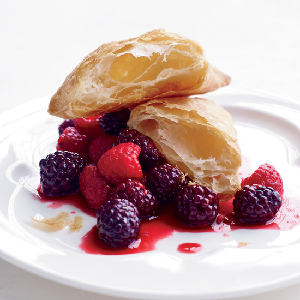

VGG16 generated feature maps:


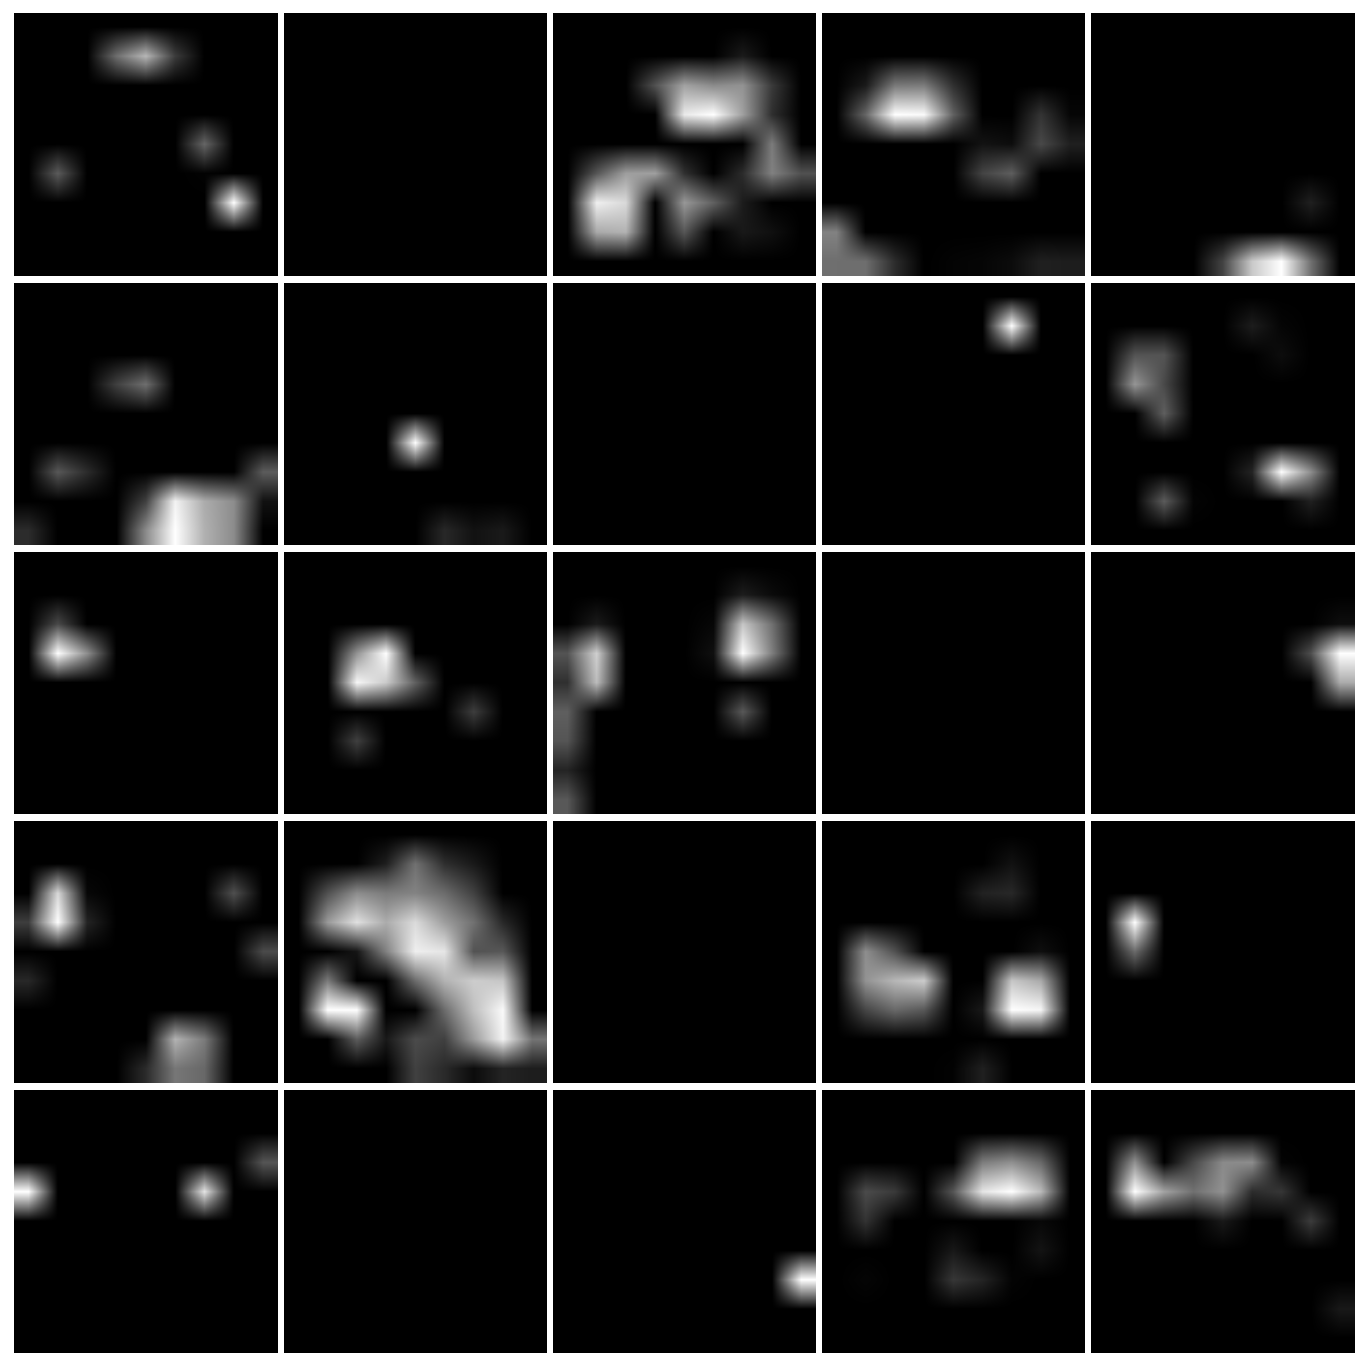

In [47]:
fig, ax = plt.subplots(5,5, figsize=(12, 12))
fig.subplots_adjust(hspace = .025, wspace = .025)

print('Original image:')
display(demo_img)

print('VGG16 generated feature maps:')
for i in range(25):
    plt.subplot(5,5, i+1)
    plt.xticks([], []), plt.yticks([], [])
    plt.imshow(feature_maps[0,:,:,i])
    plt.gray();

### Load feature maps 

In [4]:
train_features = np.load('feature_maps/train_features.npy')
train_labels = np.load('feature_maps/train_labels.npy')

validation_features = np.load('feature_maps/validation_features.npy')
validation_labels = np.load('feature_maps/validation_labels.npy')

train_features.shape, train_labels.shape, validation_features.shape, validation_labels.shape

((2400, 4, 4, 512), (2400,), (800, 4, 4, 512), (800,))

### Reshape feature maps 
Flatten to be correct input dimension to pass to our classifiers. Alternatively, we could've added a `Flatten` layer from Keras as the first layer in the below networks.

In [5]:
train_features = np.reshape(train_features, (2400, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (800, 4 * 4 * 512))

train_features.shape, validation_features.shape

((2400, 8192), (800, 8192))

## Model exploration

### Some helper functions
To visualize model learning progress and save model architecture and best weights during training.

In [8]:
class TrainingVisualizer(History):
    def on_epoch_end(self, epoch, logs={}):
        super().on_epoch_end(epoch, logs)
        clear_output(wait=True)
        pd.DataFrame(self.history).plot()
        plt.show()
        
def checkpoint(model_name):
  return ModelCheckpoint("model_files/VGG16_models/"+model_name+".hdf5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')

### Simple classifer (no hidden units)
Only one fully connected output layer — this is essentially logistic regression.

In [9]:
model_simple = Sequential()
model_simple.add(Dense(1, activation='sigmoid', input_dim=4 * 4 * 512))

model_simple.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model_simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 8193      
Total params: 8,193
Trainable params: 8,193
Non-trainable params: 0
_________________________________________________________________


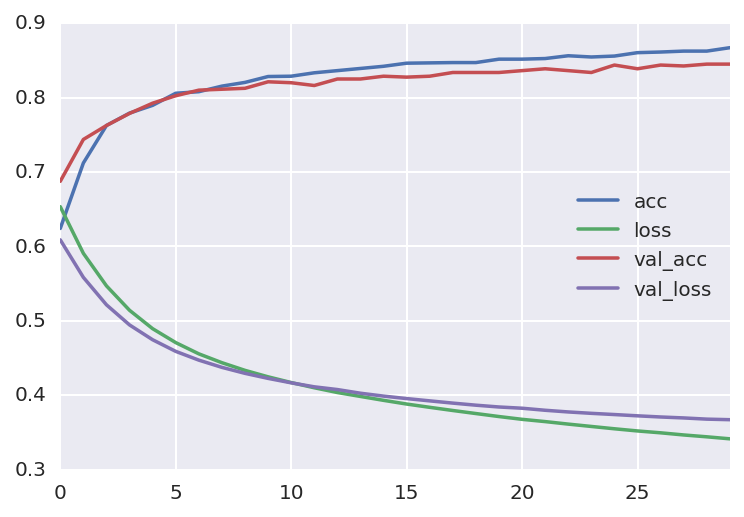

2400/2400 [==============================] - 0s - loss: 0.3414 - acc: 0.8671 - val_loss: 0.3671 - val_acc: 0.8450


In [10]:
history_simple = model_simple.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint('model_simple'),TrainingVisualizer()])

### Classifer with 64 hidden units
In addition to the single dense layer, add another fully connected layer with 64 hidden units.

In [14]:
model_64 = Sequential()
model_64.add(Dense(64, activation='relu', input_dim=4 * 4 * 512))
model_64.add(Dense(1, activation='sigmoid'))

model_64.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 64)                524352    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 524,417
Trainable params: 524,417
Non-trainable params: 0
_________________________________________________________________


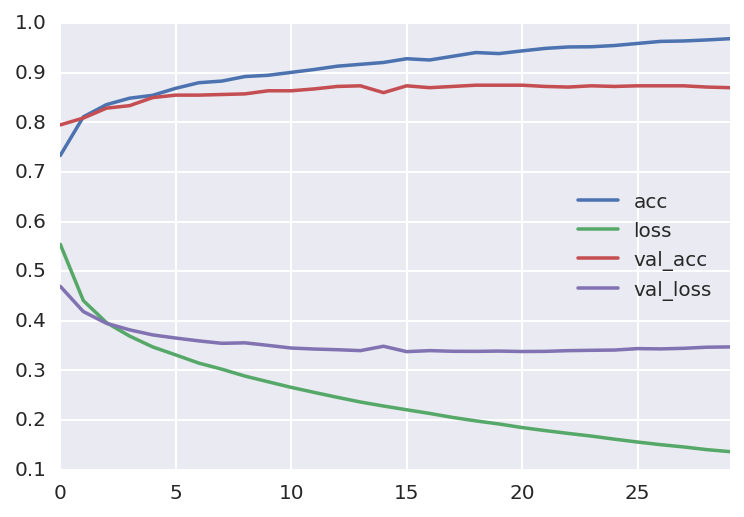

2400/2400 [==============================] - 1s - loss: 0.1362 - acc: 0.9687 - val_loss: 0.3473 - val_acc: 0.8700


In [15]:
history_64 = model_64.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint('model_64'),TrainingVisualizer()])

### Classifer with 256 hidden units
Add an additional  hidden layer with 256 hidden units. Include 50% dropout for regularization.

In [16]:
model_256 = Sequential()
model_256.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_256.add(Dropout(0.5))
model_256.add(Dense(1, activation='sigmoid'))

model_256.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model_256.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


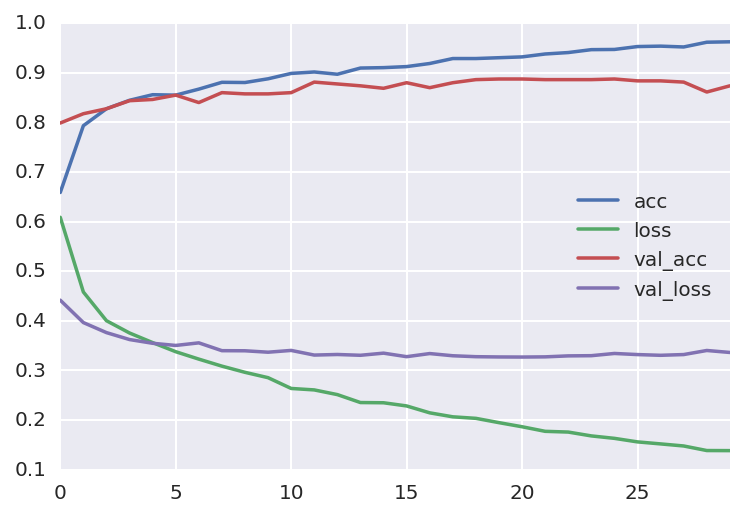

2400/2400 [==============================] - 7s - loss: 0.1383 - acc: 0.9625 - val_loss: 0.3362 - val_acc: 0.8737


In [17]:
history_256 = model_256.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint('model_256'),TrainingVisualizer()])

### Classifer with 2 layers of 64 hidden units
Add two hidden layers with 64 hidden units each. Regularize each layer with 25% dropout.

In [18]:
model_64_64 = Sequential()
model_64_64.add(Dense(64, activation='relu', input_dim=4 * 4 * 512))
model_64_64.add(Dropout(0.25))
model_64_64.add(Dense(64, activation='relu'))
model_64_64.add(Dropout(0.25))
model_64_64.add(Dense(1, activation='sigmoid'))

model_64_64.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model_64_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 64)                524352    
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 528,577
Trainable params: 528,577
Non-trainable params: 0
_________________________________________________________________


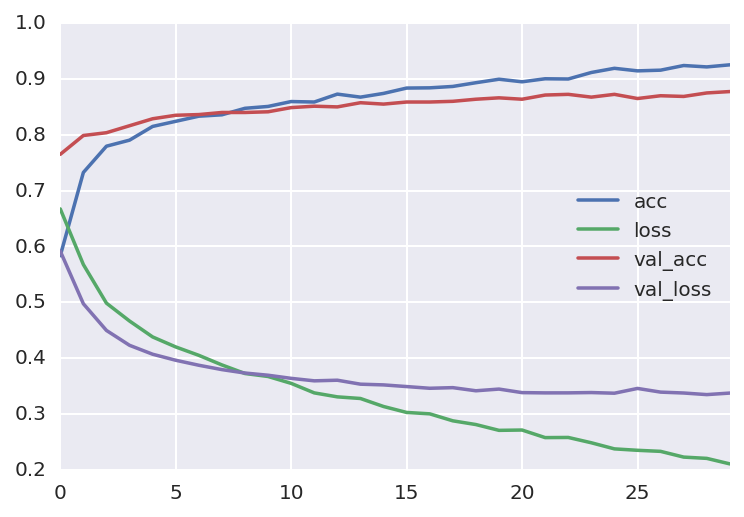

2400/2400 [==============================] - 4s - loss: 0.2102 - acc: 0.9254 - val_loss: 0.3372 - val_acc: 0.8775


In [19]:
history_64_64 = model_64_64.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint('model_64_64'),TrainingVisualizer()])

### Classifer with 2 layers of 256, 64 hidden units
Add two hidden layers with 256 and 64 hidden units, respectively. Regularize each layer with 25% dropout.

In [20]:
model_256_64 = Sequential()
model_256_64.add(Dense(256, activation='relu', input_dim=4 * 4 * 512))
model_256_64.add(Dropout(0.25))
model_256_64.add(Dense(64, activation='relu'))
model_256_64.add(Dropout(0.25))
model_256_64.add(Dense(1, activation='sigmoid'))

model_256_64.compile(optimizer=RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])
model_256_64.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 65        
Total params: 2,113,921
Trainable params: 2,113,921
Non-trainable params: 0
_________________________________________________________________


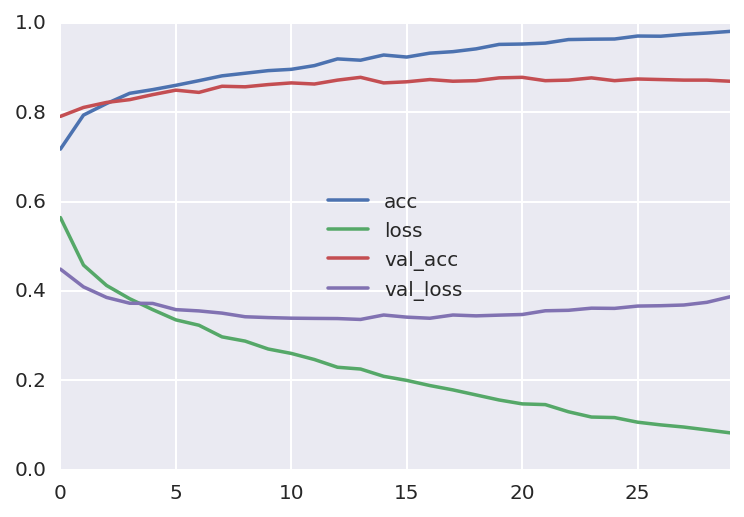

2400/2400 [==============================] - 7s - loss: 0.0823 - acc: 0.9817 - val_loss: 0.3871 - val_acc: 0.8700


In [21]:
history_256_64 = model_256_64.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels),
                    callbacks=[checkpoint('model_256_64'),TrainingVisualizer()])

### Learning Curves

In [17]:
model_histories = [history_simple, history_64, history_256, history_64_64, history_256_64]
model_names = ["Simple model", "64 hidden unit model", "256 hidden unit model", "2 layer 64 hidden unit model", "2 layer 256,64 hidden unit model"]

In [18]:
def learning_plot(history_list, train_metric, val_metric, model_names, plot_title):
    plt.subplots(figsize=(12, 8))
    epochs = range(30)
    for c, history, model_name in zip(['r', 'g', 'b', 'y', 'm'], history_list, model_names):
        plt.plot(epochs, history.history[train_metric], c+'--', label=model_name + ' train ' + train_metric)
        plt.plot(epochs, history.history[val_metric], c, label=model_name + ' ' + val_metric)

    plt.title('Training and validation ' + plot_title)
    plt.legend(loc="best");

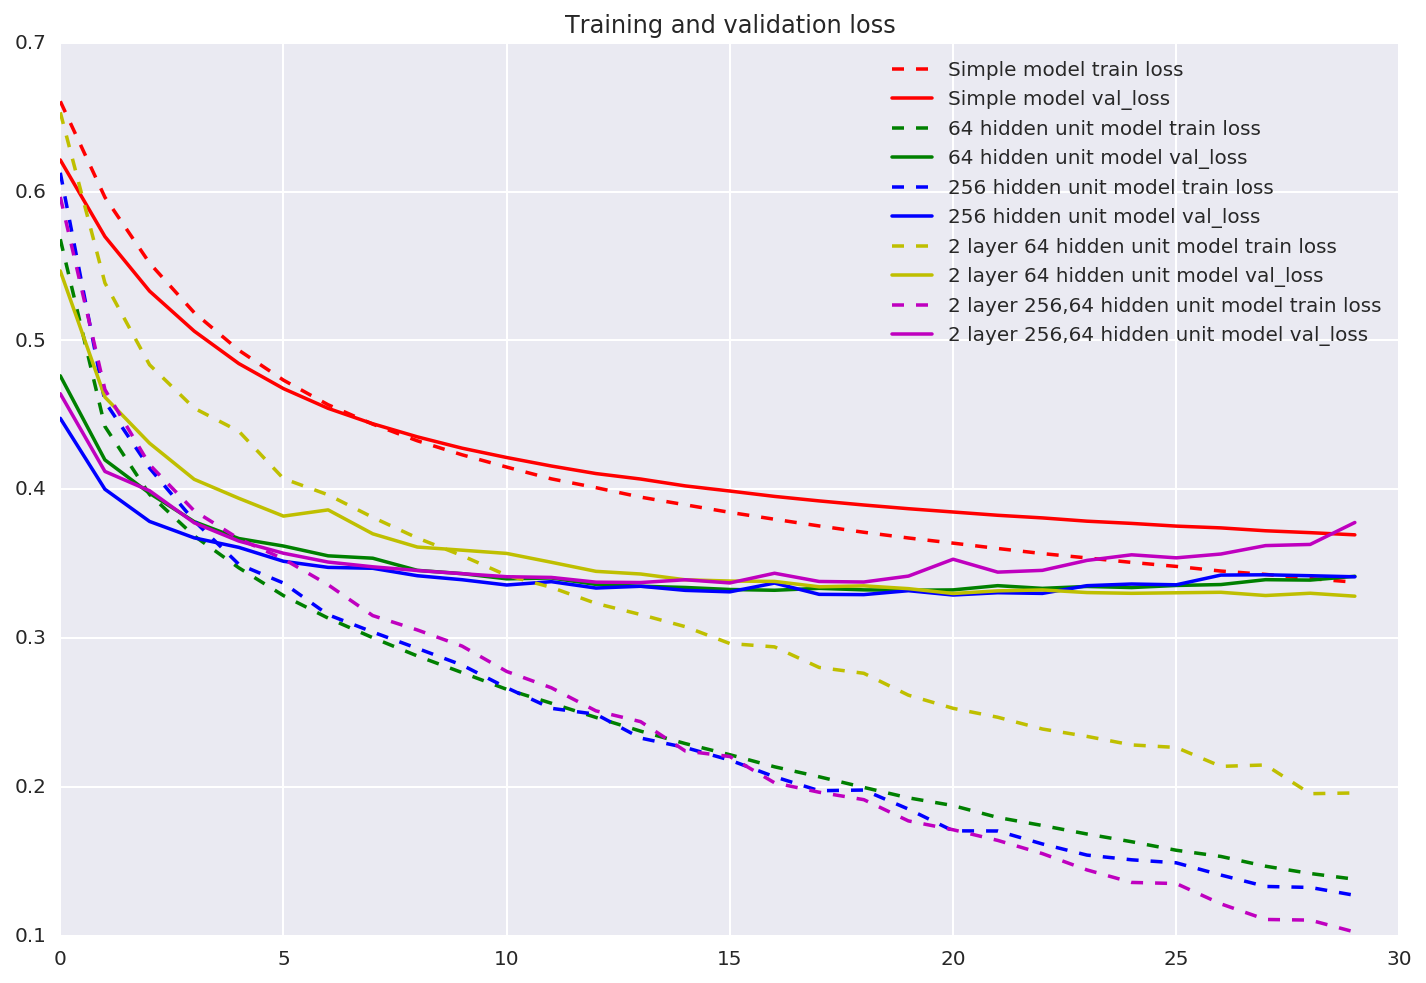

In [19]:
learning_plot(model_histories, 'loss', 'val_loss', model_names, 'loss')

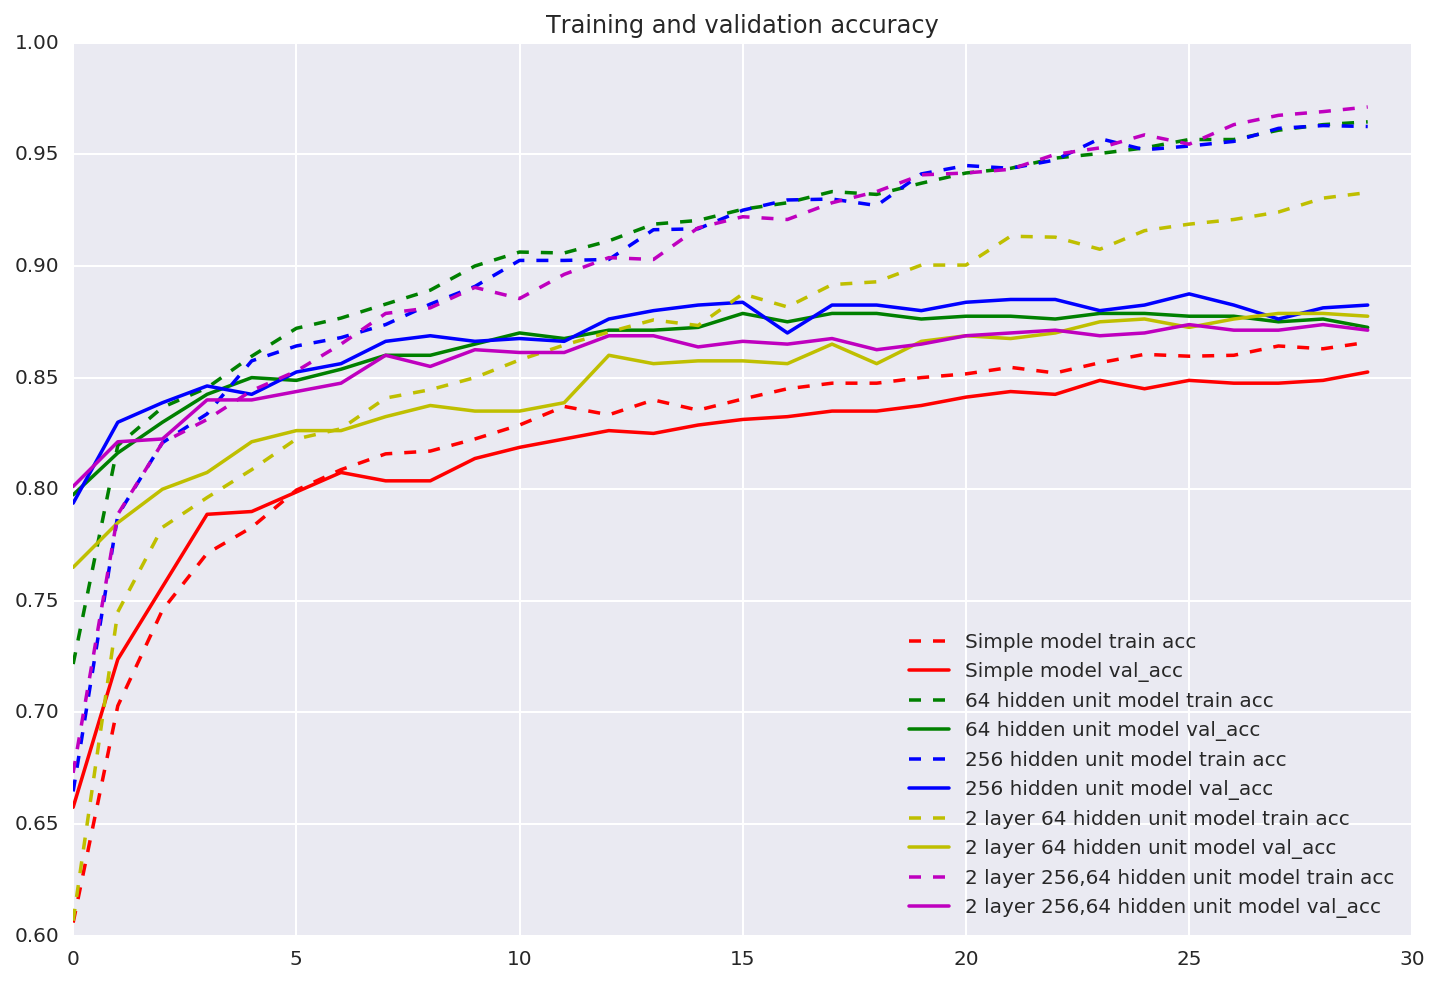

In [20]:
learning_plot(model_histories, 'acc', 'val_acc', model_names, 'accuracy')

In [21]:
def compare_acc(history, model_type):
  print(model_type+"\n--------------------------------------------")
  print('Best validation accuracy (epoch = {0:d}): {1:.3f}'.format(np.argmax(history.history['val_acc']), max(history.history['val_acc'])))
  print('Training accuracy (epoch = {0:d}): {1:.3f}'.format(np.argmax(history.history['val_acc']), max(history.history['acc'])))
  delta = abs(max(history.history['val_acc']) - max(history.history['acc']))
  print('Delta(training - validation): {0:.3f} \n'.format(delta))

for i in zip(model_histories, model_names):
    compare_acc(*i)

Simple model
--------------------------------------------
Best validation accuracy (epoch = 29): 0.853
Training accuracy (epoch = 29): 0.866
Delta(training - validation): 0.013 

64 hidden unit model
--------------------------------------------
Best validation accuracy (epoch = 23): 0.879
Training accuracy (epoch = 23): 0.965
Delta(training - validation): 0.086 

256 hidden unit model
--------------------------------------------
Best validation accuracy (epoch = 25): 0.887
Training accuracy (epoch = 25): 0.963
Delta(training - validation): 0.075 

2 layer 64 hidden unit model
--------------------------------------------
Best validation accuracy (epoch = 27): 0.879
Training accuracy (epoch = 27): 0.933
Delta(training - validation): 0.054 

2 layer 256,64 hidden unit model
--------------------------------------------
Best validation accuracy (epoch = 25): 0.874
Training accuracy (epoch = 25): 0.971
Delta(training - validation): 0.097 



## Comparison to linear models

Pass feature maps through non-neural linear models from scikit-learn to compare results to the above model exploration.

### SGDClassifier with log loss
Logistic regression.

In [4]:
lr_model = linear_model.SGDClassifier(loss='log')
lr_model.fit(train_features, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [5]:
lr_model.score(validation_features, validation_labels)

0.77375000000000005

### SGDClassifier with hinge loss
This returns a SVM classifier — SVMs have been shown to performed well for similar image classification problems.

In [6]:
svm_model = linear_model.SGDClassifier(loss='hinge')
svm_model.fit(train_features, train_labels)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

In [7]:
svm_model.score(validation_features, validation_labels)

0.83374999999999999